<a href="https://colab.research.google.com/github/AshishRaj04/makemore/blob/main/makemore_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
data_path = "/content/drive/MyDrive/Projects/ building makemore part 1/anime_names.txt"

Importing modules

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

Reading anima names in names list

In [3]:
with open(data_path, "r") as f:
  names = f.read().splitlines()

In [4]:
len(names)

72776

In [5]:
print(names[ : 20])

['Pie_a_La_Mode', 'Celica_A_Mercury', 'Konoe_A_Mercury', 'Priapus_A_Tarou', 'Faalala_Aa_Larm', 'Torry_Aaes', 'Angel_Aaltonen', 'Diana_Aaman', 'Itsue_Aasu', 'Futaba_Aasu', 'Hitomi_Aasu', 'Nanase_Aasu', 'Mitsuki_Aasu', 'Mutsumi_Aasu', 'Shii_Aasu', 'Lashara_Aasu_XXVIII', 'Kim_Aba', 'Iouri_Abalkin', 'Renji_Abarai', 'Ichika_Abarai']


In [6]:
chars = sorted(list(set("".join(names))))

There are total of 66 characters

In [7]:
len(chars)

66

Creating a dict of characters having index to character mapping

In [8]:
str_to_idx = {ch : i+1 for i , ch in enumerate(chars)}
str_to_idx["."] = 0
idx_to_str = {i : ch for ch , i in str_to_idx.items()}
print(idx_to_str)

{1: '#', 2: '-', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: '?', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'O', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z', 40: '_', 41: 'a', 42: 'b', 43: 'c', 44: 'd', 45: 'e', 46: 'f', 47: 'g', 48: 'h', 49: 'i', 50: 'j', 51: 'k', 52: 'l', 53: 'm', 54: 'n', 55: 'o', 56: 'p', 57: 'q', 58: 'r', 59: 's', 60: 't', 61: 'u', 62: 'v', 63: 'w', 64: 'x', 65: 'y', 66: 'z', 0: '.'}


- Using context length of 8
- Using only 30k names for traning due to insufficient RAM.
- X , Y tensors are data

In [10]:
context_len = 8
def build_dataset(names):
  X , Y = [] , []

  for name in names[ : 30000]:
    context = [0] * context_len
    for ch in name + ".":
      ix = str_to_idx[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = tf.convert_to_tensor(X)
  Y = tf.convert_to_tensor(Y)
  print(X.shape , Y.shape)
  return X , Y

Spliting the data into traning , validation an test data

In [11]:
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr , Ytr = build_dataset(names[:n1])
Xdev , Ydev = build_dataset(names[n1:n2])
Xte , Yte = build_dataset(names[n2:])

(430149, 8) (430149,)
(104753, 8) (104753,)
(104419, 8) (104419,)


## Multilayer Perceptron

- **67 chars to predict**

Hyperparameters

In [12]:
n_emb = 45
n_neurons_l1 = 300
n_neurons_l2 = 250
n_neurons = n_neurons_l1 + n_neurons_l2
vocab_size = len(idx_to_str) # 67
context_len = 8
# n_emb(45) * context_len(4) = 180

Trainable parameters

In [13]:
seed = tf.random.set_seed(424242424)
initializer = tf.keras.initializers.HeNormal(seed=seed)

C = tf.Variable(tf.random.uniform(shape=(vocab_size , n_emb) , seed = seed))

W1 = tf.Variable(initializer(shape=(n_emb*context_len , n_neurons_l1)))
b1 = tf.Variable(tf.random.uniform(shape=[n_neurons_l1]))

W2 = tf.Variable(initializer(shape=(n_neurons_l1 , n_neurons_l2)))
b2 = tf.Variable(tf.random.uniform(shape = [n_neurons_l2]))

W3 = tf.Variable(initializer(shape=(n_neurons_l2 , vocab_size)))
b3 = tf.Variable(tf.random.uniform(shape = [vocab_size]))


Loss function - categorical cross-entropy

In [14]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

**0.2M PARAMETER DNN-MODEL**

In [15]:
parameters = [C , W1 , b1 , W2 , b2 , W3 , b3]
no_params = 0
for p in parameters:
  no_params += tf.size(p).numpy()

print('Total number of parameters: ', no_params.item())

Total number of parameters:  203382


- Initially we want each character to have equal probability i.e; 1/67 .
- -tf.math.log(1/67) = 4.20
- We got 5.4186 on first epoch . So we have initiallized our weights well.
- Also using tanh in such a large dnn might led to saturation of many of the neurons .
- Hence we are using gelu. It might me computationally expensive.

Traning loop of 500 epochs

In [17]:
num_epochs = 500
learning_rate = 0.01
losses = []
# Instantiate the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        # Forward pass:
        emb = tf.gather(C,Xtr) # [batch, block_size, embedding_dim]
        h1 = tf.keras.activations.gelu((tf.reshape(emb , shape=(-1 , n_emb*context_len)) @ W1) + b1)
        h2 = tf.keras.activations.gelu(h1 @ W2 + b2)
        logits = h2 @ W3 + b3
        loss = loss_fn(tf.reshape(Ytr, [-1]), logits)


    # Compute the gradients with respect to parameters
    grads = tape.gradient(loss, parameters)

    # Update parameters using the Adam optimizer
    optimizer.apply_gradients(zip(grads, parameters))

    losses.append(loss.numpy())

    if epoch % 25 == 0:
      print(f"epoch={epoch}, loss={loss.numpy():.4f}")

epoch=0, loss=5.4186
epoch=25, loss=2.5524
epoch=50, loss=2.2234
epoch=75, loss=2.1361
epoch=100, loss=2.0496
epoch=125, loss=2.0082
epoch=150, loss=1.9662
epoch=175, loss=1.9362
epoch=200, loss=1.9119
epoch=225, loss=1.9021
epoch=250, loss=1.8688
epoch=275, loss=1.8636
epoch=300, loss=1.8418
epoch=325, loss=1.8211
epoch=350, loss=1.8102
epoch=375, loss=1.7925
epoch=400, loss=1.7867
epoch=425, loss=1.7833
epoch=450, loss=1.7632
epoch=475, loss=1.7479


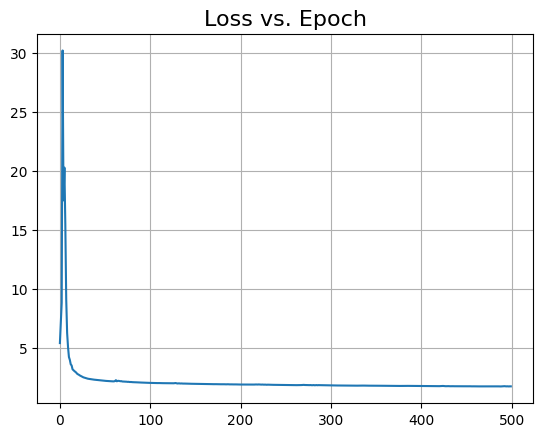

In [24]:
plt.plot(losses)
plt.title('Loss vs. Epoch', fontsize=16)
plt.grid(True)
plt.show()

Traning loss

In [27]:
print("Traning loss: ",losses[-1].item())

Traning loss:  1.756134033203125


Validation loss

In [28]:
emb = tf.gather(C,Xdev) # [batch, block_size, embedding_dim]
h1 = tf.keras.activations.gelu((tf.reshape(emb , shape=(-1 , n_emb*context_len)) @ W1) + b1)
h2 = tf.keras.activations.gelu(h1 @ W2 + b2)
logits = h2 @ W3 + b3
loss = loss_fn(tf.reshape(Ydev, [-1]), logits)
print("Validation loss: ",loss.numpy().item())

Validation loss:  1.818256139755249


Sampling newly generated names

In [29]:
block_size = 8
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = tf.gather(C , tf.constant([context] , dtype=tf.int32)) # (1,block_size,d)
      emb_flat = tf.reshape(emb, [1, -1])
      h1 = tf.keras.activations.gelu(tf.matmul(emb_flat, W1) + b1)
      h2 = tf.keras.activations.gelu(tf.matmul(h1, W2) + b2)
      logits = tf.matmul(h2, W3) + b3 # (B,block_size,vocab_size)
      probs = tf.nn.softmax(logits, axis=1)
      ix = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0].numpy()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(idx_to_str[i] for i in out))

Wakanekatsurya.
Minami_Chinamine.
Shuuka_Shizaki.
Sakir-Poc_Erens.
Milly_Lelinwaho.
Fujima_Yamino.
Gitzumi_Joumonji.
Yura_Roura.
Hikuko_Mura.
Nanami_Sawamura.
Kotouhon_Shimarumi.
Shizuku_Yuuki.
Kazue_Horoshi.
Nanhei_Seioku.
Min_Misumoto.
Fudone_Arogawa.
Nallyan.
Matsune_Flarsere.
Mashou_Narasegu.
Geiki_Shizuha.


Saving the trained weights

In [22]:
checkpoint = tf.train.Checkpoint(
    C = C , W1 = W1 , b1 = b1 , W2 = W2 , b2 = b2 , W3 = W3 , b3 = b3
)

save_path = checkpoint.save("./checkpoints/anime_model")
print(f"Model saved at: {save_path}")

Model saved at: ./checkpoints/anime_model-1


For restoring the saved weights

In [30]:
# checkpoint = tf.train.Checkpoint(
#     C=C, W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3
# )

# checkpoint.restore(tf.train.latest_checkpoint("./checkpoints")).expect_partial()
# print("Model restored from latest checkpoint!")